# Определение перспективного тарифа для телеком-компании

Нужно сделать анализ для сотового оператора. Он предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Необходимо понять, какой тариф приносит больше денег.
Анализ тарифов будет на небольшой выборке клиентов. (500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год). На этих данных нужно сделать выводы о всей генеральной совокупности, используя статистические методы анализа

## Изучение и предобработка данных

Данные, необходимые для исследования, мы берем из нескольких файлов. По отдельности откроем каждый из них, проверим и проведем необходимые преобразования.

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import datetime
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
calls=pd.read_csv('/datasets/calls.csv')
internet=pd.read_csv('/datasets/internet.csv', index_col=0)
messages=pd.read_csv('/datasets/messages.csv')
tariffs=pd.read_csv('/datasets/tariffs.csv')
users=pd.read_csv('/datasets/users.csv')


### Calls

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В файле 202_607 строк, нет пропусков. Здесь содержатся данные о совершенных звонках абонентами. Нули в duration это пропущенные звонки. Дата в формате строки.

In [5]:
#преобразуем в формат дата
calls['call_date']= pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [6]:
#создадим столбец с указанием месяца звонка
calls['month'] = pd.DatetimeIndex(calls['call_date']).month


In [7]:
#проверили, что данные только за 2018 год
pd.DatetimeIndex(calls['call_date']).year.unique()

Int64Index([2018], dtype='int64', name='call_date')

In [8]:
#согласно тарифам округлим секунды до минут, чтобы нули (пропущенные звонки) остались нулями.
calls['duration']= np.ceil(calls['duration']).astype('int')

In [9]:
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


In [10]:
#сгруппируем данные по user_id и month для дальнейшего объединения данных 
calls = calls.groupby(['user_id', 'month']).agg({'duration': ['count','sum']}).reset_index()

In [11]:
calls.columns = ['user_id', 'month', 'calls_count', 'calls_minutes'] 

In [12]:
calls.head() #датасет после преобразований

,user_id,month,calls_count,calls_minutes
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


### Internet

In [13]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,"1,052.81",2018-09-07,1000
2,1000_2,"1,197.26",2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [14]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


В файле 149_396 строк, нет пропусков. Здесь содержатся данные об интернет-сессиях абонентов.

In [15]:
#преобразуем в формат дата
internet['session_date']= pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [16]:
#создадим столбец с указанием месяца сессии
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [17]:
#сгруппируем данные по user_id и month для дальнейшего объединения данных 
internet = internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()

In [18]:
#переведем мегабайты в гигабайты и округлим до целого, согласно тарифным планам
internet['gb_used']=(internet['mb_used']/1024).apply(np.ceil).astype(int)

In [19]:
internet.head() #датасет после преобразований

,user_id,month,mb_used,gb_used
0,1000,5,"2,253.49",3
1,1000,6,"23,233.77",23
2,1000,7,"14,003.64",14
3,1000,8,"14,055.93",14
4,1000,9,"14,568.91",15


### Messages

In [20]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [21]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В файле 123_036 строк, нет пропусков. Дата в формате строки. Здесь содержатся данные о текстовых сообщениях, отправленных абонентами.

In [22]:
#преобразуем в формат дата
messages['message_date']= pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [23]:
#создадим столбец с указанием месяца 
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [24]:
#сгруппируем данные по user_id и month для дальнейшего объединения данных 
messages = messages.groupby(['user_id', 'month']).agg({'id': 'count'}).reset_index()

In [25]:
messages.rename(columns={'id': 'messages_count'}, inplace=True)

In [26]:
messages.head() #датасет после преобразований

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


### Tariffs

In [27]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [28]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Здесь содержатся все необходимые данные для расчета абонентской платы по двум тарифам.

In [29]:
# переводим мб в гб
tariffs['gb_per_month_included']=tariffs['mb_per_month_included']/1024

In [30]:
# переимнуем столбец, для объединения
#tariffs.rename(columns={'tariff_name': 'tariff'}, inplace=True)

In [31]:
#избавляемся от ненужного столбца
tariffs = tariffs.drop('mb_per_month_included', axis=1)

In [32]:
tariffs #датасет после преобразований

,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,500,550,200,3,3,smart,15.00
1,1000,3000,1950,150,1,1,ultra,30.00


### Users

In [33]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [34]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В этом датасете содержатся данные об абоентах. Абонентов, пользующихся smart больше более чем в два раза в этой выборке.

In [35]:
users['user_id'].nunique()

500

Все user_id уникальны, дубликатов нет. Нет абонентов, пользовавшихся обоими тарифами. Нет пропусков в столбце city.

In [36]:
users[~users['churn_date'].isna()].groupby(['tariff']).agg({'user_id': 'count'}).reset_index()

,tariff,user_id
0,smart,23
1,ultra,15


Соотношения по прекратившим пользоваться тарифами, примерно такое же как и в целом по абонентам. В последующем этот столбец использовать не будем.

###  Объединение данных

In [37]:
report = calls.merge(internet, on = ['user_id', 'month'], how = 'outer')

In [38]:
report = report.merge(messages, on = ['user_id', 'month'], how = 'outer')

In [39]:
report = report.merge(users, on = 'user_id', how= 'left')

In [40]:
report = report.drop(['mb_used', 'age', 'churn_date', 'first_name', 'last_name', 'reg_date'], axis=1)

In [41]:
report = report.merge(tariffs, left_on = 'tariff', right_on = 'tariff_name', how = 'left')

In [42]:
# заменим Nan на нули. 
# Пропуски в объединенной таблице означают, что абонент не пользовался смс, звонками, тарфиком.
report = report.fillna(0)

In [43]:
# Заменим тип данных на целочисленный
int_list = ['calls_count', 'calls_minutes', 'gb_used', 'messages_count']
for item in int_list:
    report[item] = report[item].astype('int')
    

In [44]:
report.head() #объединенная таблица

,user_id,month,calls_count,calls_minutes,gb_used,messages_count,city,tariff,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,1000,5,22,159,3,22,Краснодар,ultra,1000,3000,1950,150,1,1,ultra,30.00
1,1000,6,43,172,23,60,Краснодар,ultra,1000,3000,1950,150,1,1,ultra,30.00
2,1000,7,47,340,14,75,Краснодар,ultra,1000,3000,1950,150,1,1,ultra,30.00
3,1000,8,52,408,14,81,Краснодар,ultra,1000,3000,1950,150,1,1,ultra,30.00
4,1000,9,58,466,15,57,Краснодар,ultra,1000,3000,1950,150,1,1,ultra,30.00


Объединенная таблица содержит для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;

Данные для нашего анализа содержатся в нескольких таблицах.  На данном этапе мы 
* удостоверились, что нет пропусков в нужных нам столбцах, 
* преобразовали столбцы с датой в нужный формат,
* добавили колонку month, необходимую  
* округлили секунды и мегабайты согласно требованиям тарифов,
* сгруппировали данные о минутах, сообщениях, трафике по абонентам и месяцам в отдельных таблицах,
* переименовали столбцы, где это необходимо
* объединили необходимые данные из отдельных таблиц в один датасет
* заменили пропуски нулями в объединенной таблице
* заменили тип данных на целочисленный, где это необходимо,
* посчитали среднюю выручку по абоненту в месяц

Также выявили, что тариф Ультра пользуется намного меньшим спросом чем Смарт. Количество абонентов в тарифе Смарт первышает количество абонентов в Ультра более чем в два раза.

### Расчет выручки

В столбце **fee** будет помесячнаю выручка с каждого пользователя

In [45]:
# считаем расходы сверх лимита
report['calls_over'] = (report['calls_minutes'] - report['minutes_included']) *  report['rub_per_minute']
report['msg_over'] = (report['messages_count'] - report['messages_included']) *  report['rub_per_message']
report['gb_over'] = (report['gb_used'] - report['gb_per_month_included']) *  report['rub_per_gb']

# убираем отрицательные суммы
#report.loc[report['calls_over'] < 0, 'calls_over'] = 0
#report.loc[report['msg_over'] < 0, 'msg_over'] = 0
#report.loc[report['gb_over'] < 0, 'gb_over'] = 0

report['calls_over'] = report['calls_over'].clip(0)
report['msg_over'] = report['msg_over'].clip(0)
report['gb_over'] = report['gb_over'].clip(0)

# считаем выручку
report['fee'] = report['rub_monthly_fee'] + report['calls_over'] + report['msg_over'] + report['gb_over']

In [46]:
report.head()

,user_id,month,calls_count,calls_minutes,gb_used,messages_count,city,tariff,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included,calls_over,msg_over,gb_over,fee
0,1000,5,22,159,3,22,Краснодар,ultra,1000,3000,1950,150,1,1,ultra,30.00,0,0,0.00,"1,950.00"
1,1000,6,43,172,23,60,Краснодар,ultra,1000,3000,1950,150,1,1,ultra,30.00,0,0,0.00,"1,950.00"
2,1000,7,47,340,14,75,Краснодар,ultra,1000,3000,1950,150,1,1,ultra,30.00,0,0,0.00,"1,950.00"
3,1000,8,52,408,14,81,Краснодар,ultra,1000,3000,1950,150,1,1,ultra,30.00,0,0,0.00,"1,950.00"
4,1000,9,58,466,15,57,Краснодар,ultra,1000,3000,1950,150,1,1,ultra,30.00,0,0,0.00,"1,950.00"


### Вывод

Данные для нашего анализа содержатся в нескольких таблицах.  На данном этапе мы 
* удостоверились, что нет пропусков в нужных нам столбцах, 
* преобразовали столбцы с датой в нужный формат,
* добавили колонку month, необходимую  
* округлили секунды и мегабайты согласно требованиям тарифов,
* сгруппировали данные о минутах, сообщениях, трафике по абонентам и месяцам в отдельных таблицах,
* переименовали столбцы, где это необходимо
* объединили необходимые данные из отдельных таблиц в один датасет
* заменили пропуски нулями в объединенной таблице
* заменили тип данных на целочисленный, где это необходимо,
* посчитали среднюю выручку по абоненту в месяц

Также выявили, что тариф Ультра пользуется намного меньшим спросом чем Смарт. Количество абонентов в тарифе Смарт первышает количество абонентов в Ультра более чем в два раза.

## Анализ данных

### Расчет статистических показателей

In [47]:
# создадим сводную таблицу для рассчита стат показетелей
(
    report.groupby('tariff')
    .agg({'calls_minutes': ['mean', 'std', 'var'], 
          'messages_count': ['mean', 'std', 'var'], 'gb_used': ['mean', 'std', 'var']})
)


calls_minutes                   messages_count                gb_used  \
                mean    std        var           mean   std      var    mean   
tariff                                                                         
smart         417.93 190.31  36,219.32          33.38 28.23   796.81   16.33   
ultra         526.62 317.61 100,873.63          49.36 47.80 2,285.27   19.49   

                   
        std   var  
tariff             
smart  5.75 33.03  
ultra  9.85 97.09

Для двух тарифов посчитали **среднее**, **дисперсию** и **стандартное отклонение** для:
* cколько в среднем абонент разговаривает минут в месяц **calls_minutes**
* сколько в среднем абонент отправляет сообщений в месяц **messages_count**
* размер трафика в среднем в месяц **gb_used**

Для абонентов тарифа ультра стандартное отклонение и дисперсия намного больше чем у тарифа смарт. Это происходит из-за того, что лимит у Ультра больше, а следовательно и возможностей принимать разные значения у переменных больше, а также из-за меньшего размера выборки.

### Описание поведение клиентов оператора

Опишем поведение клиентов оператора, исходя из выборки по основным параметрам. 
* Сколько минут разговора, 
* сколько сообщений и 
* какой объём интернет-трафика требуется пользователям каждого тарифа в месяц

In [48]:
# создадим сводную таблицу со сравнениями основных средних параметров у двух тарифов
report_means = report.pivot_table(index='tariff', values=['calls_count', 'calls_minutes', 'messages_count', 'gb_used', 'fee'])

# добавим в сводную таблицу строку 'ratio', где будет показн результат сравнения  smart и ultra
# в относительной форме по основным параметрам
ratio_calls_count = (report_means.loc['ultra']['calls_count']-report_means.loc['smart']['calls_count'])/report_means.loc['smart']['calls_count']

ratio_calls_minutes = (report_means.loc['ultra']['calls_minutes']-report_means.loc['smart']['calls_minutes'])/report_means.loc['smart']['calls_minutes']

ratio_fee = (report_means.loc['ultra']['fee']-report_means.loc['smart']['fee'])/report_means.loc['smart']['fee']

ratio_gb_used = (report_means.loc['ultra']['gb_used']-report_means.loc['smart']['gb_used'])/report_means.loc['smart']['gb_used']

ratio_msg = (report_means.loc['ultra']['messages_count']-report_means.loc['smart']['messages_count'])/report_means.loc['smart']['messages_count']

report_means.loc['ratio'] = [ratio_calls_count, ratio_calls_minutes, ratio_fee, ratio_gb_used, ratio_msg] 

In [49]:
## вставим в таблицу лимиты тарифных планов для наглядности
report_means.loc['limit_smart'] = [0, tariffs.loc[0,'minutes_included'], tariffs.loc[0, 'rub_monthly_fee'], tariffs.loc[0, 'gb_per_month_included'], tariffs.loc[0, 'messages_included']]  

report_means.loc['limit_ultra'] = [0, tariffs.loc[1,'minutes_included'], tariffs.loc[1, 'rub_monthly_fee'], tariffs.loc[1, 'gb_per_month_included'], tariffs.loc[1, 'messages_included']]

In [50]:
report_means.head()

,calls_count,calls_minutes,fee,gb_used,messages_count
tariff,,,,,
smart,58.46,417.93,"1,289.97",16.33,33.38
ultra,73.39,526.62,"2,070.15",19.49,49.36
ratio,0.26,0.26,0.60,0.19,0.48
limit_smart,0.00,500.00,550.00,15.00,50.00
limit_ultra,0.00,"3,000.00","1,950.00",30.00,"1,000.00"


**Смарт**

В среднем абоненты тарифа смарт тратили на разговоры 418 минут в месяц, что чуть меньше лимита - 500 мин. Также они в среднем использовали 16,3 гб (или 17 согласно правилам округления тарифных планов) тарфика, что немного превышает тарифный лимит в 15 гб. Возможно часто это чисто-технический момент, из-за округления до полных гб в конце месяца. Также они в среднем отправляли по 33 сообщения, что значительно ниже лимита в 50 сообщений. Средняя выручка по тарифу смарт составила 1290 рублей, что превышает абонентскую плату в 550 руб более чем в два раза. Это, видимо, свидетельствует о дорогих дополнительных минутах и гб.

**Ультра**

Абоненты тарифа ультра в среднем тратили на разговоры 527 минут в месяц, что всего на 26% больше, чем у тарифа смарт. Это намного меньше лимита в 3000 мин. Также они в среднем израсходовали 20 гб трафика, что также значительно ниже лимита по этому тарифу в 30 гб и на 19% больше, чем у тарифа смарт. Отправили сообщений 50 штук, что значительно ниже лимита по тарифу в 1000 сообщений. Выручка по тарифу ультра составила в среднем 2 070 руб, что чуть больше абонентской платы в 1950 руб и на 60% выше средней выручки с одного абонента в месяц по тарифу смарт. 

Иными словами, мы видим, что средние потребности абонентов тарифа ультра значительно ниже лимитов по нему и более тяготеют к тарифу смарт, превышают его показатели всего на 19-26% процентов. А стоимость услуг по тарифу ультра больше чем по тарифу смарт на 60%. По всей видимости, решающим фактором в пользу тарифа ультра является 30 гб трафика, входящих в пакет. Так как 1гб сверх по тарифу смарт стоит целых 200 руб.

### Гистограмма звонков

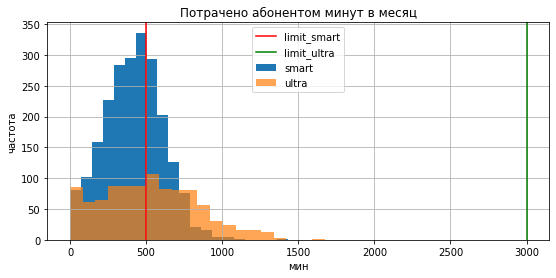

In [51]:
ax=report[report['tariff']=='smart']['calls_minutes'].hist(bins=20, figsize=(9,4))
report[report['tariff']=='ultra']['calls_minutes'].hist(ax=ax, bins=20, alpha=0.7)
plt.title('Потрачено абонентом минут в месяц')
plt.xlabel('мин')
plt.ylabel('частота')
plt.axvline(x=report_means.loc['limit_smart', 'calls_minutes'], color='r')
plt.axvline(x=report_means.loc['limit_ultra', 'calls_minutes'], color='g')
plt.legend(['limit_smart', 'limit_ultra', 'smart', 'ultra'])
plt.show()

Чаще всего абоненты смарт тратили на звонки чуть меньше 500 мин в месяц, у них получалось точно израсходовать лимит. У звонков по тарифу смарт распределение близкое к нормальному, чуть скошенное вправо. У тарифа ультра мы видим более равномерное распределение частоты среднего количества минут, с динным правым хвостом - есть небольшое количество людей говорящих много, но все равно это почти никогда не выходит за рамки лимита. В целом мы видим, что количество абонентов тарифа смарт сильно больше чем ультра.

### Гистограмма текстовых сообщений

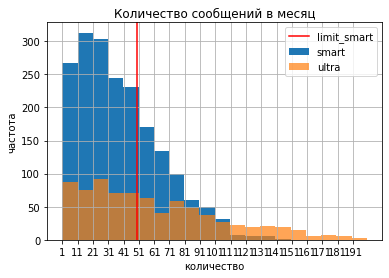

In [52]:
ax=report[report['tariff']=='smart']['messages_count'].hist(bins=20, range=(1, 200))
report[report['tariff']=='ultra']['messages_count'].hist(ax=ax, bins=20, range=(1, 200), alpha=0.7)
plt.title('Количество сообщений в месяц')
plt.xlabel('количество')
plt.ylabel('частота')
plt.xticks(range(1,200,10))
plt.axvline(x=report_means.loc['limit_smart', 'messages_count'], color='r', label='limit_smart')
plt.legend(['limit_smart', 'smart', 'ultra'])
plt.show()

In [53]:
report['messages_count'].value_counts().head()

0     497
20     52
6      46
16     45
17     44
Name: messages_count, dtype: int64

Основная масса абонентов вообще не отправляет смс. Поэтому мы убрали 0 из диапазона по оси Х. Пользователи обоих тарифов практически не отправляют больше 100 сообщений  в месяц. Чаще всего абоненты тарифа смарт отправляют от 10 до 30 сообщений в месяц. У ультра от 1 до 30. 

Если принимать во внимание только месяцы, в которые абоненты отсылали текстовые сообщения, распределение представляет собой распределение Пуасона. 

### Гистограмма интернет-трафика

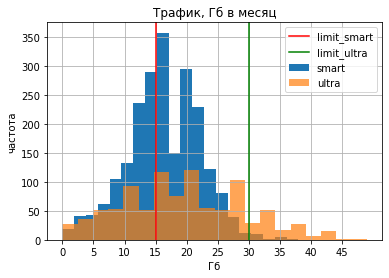

In [54]:
ax=report[report['tariff']=='smart']['gb_used'].hist(bins=20)
report[report['tariff']=='ultra']['gb_used'].hist(ax=ax, bins=20, alpha=0.7)
plt.title('Трафик, Гб в месяц')
plt.xlabel('Гб')
plt.ylabel('частота')
plt.xticks(range(0,50,5))
plt.axvline(x=report_means.loc['limit_smart', 'gb_used'], color='r')
plt.axvline(x=report_means.loc['limit_ultra', 'gb_used'], color='g')
plt.legend(['limit_smart', 'limit_ultra', 'smart', 'ultra'])
plt.show()

Наиболее частый размер тарфика в месяц по тарифу смарт  - это чуть больше 16 гб, что чуть больше лимита, с последующим провалом. И по тарифу ультра распределение более равномерно нет такого пик, чаще всего используют 10-30 гб. После 30гб (лимита) очень сильное падение.  

### Вывод

Мы сравнили основные средние показатели по двум тарифам и обнаружили, что они не так сильно различаются между собой как абонентская плата и лимиты по этим двум тарифам. По звонкам потребность абонентов более тяготеет к тарифу смарт. 

Средняя потребность в трафике чуть превышает лимит смарт, и не дотягивает до ультра 30 гб включенных в тариф ультра. Видимо, основная причина выбора тарифа ультра - дороговизна дополнительных Гб по тарифу смарт (200 руб).

СМС уже почти никто не отсылает. Потребность в них низкая и покрывается лимитом смарт.  

## Проверка гипотез

### Гипотеза 1

**Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются**

Формулировка нулевой гипотезы **Н0**: Гипотеза о равенстве средних двух генеральных совокупностей

Генеральные совокупности - это все пользователи тарифов Ультра и Смарт.


Формулировка альтернативной гипотезы **Н1**: средние генеральных совокупностей не равны между собой.

In [55]:
# выведем среднию и дисперсию по выборке
report.groupby('tariff').agg({'fee': ['mean', 'var']})


fee           
           mean        var
tariff                    
smart  1,289.97 669,785.71
ultra  2,070.15 141,516.75

Допустим, что нет оснований полагать, что дисперсии двух генеральных совокупностей примерно равны (в выборке дисперсии сильно отличаются), поэтому возьмем **equal_var = False**.

Установим пороговое значение **alpha** для уровня значимости **p-value** 5%. Если полученный **p-value** меньше 5%, то отвергаем нулевую гипотезу. 

In [56]:
sample_smart=report[report['tariff']=='smart']['fee']
sample_ultra=report[report['tariff']=='ultra']['fee']

alpha=0.05
results=st.ttest_ind(sample_smart, sample_ultra, equal_var = False )
print('p-value:', results.pvalue)
if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else: 
    print('Не получилось отвергнуть нулевую гипотезу')


p-value: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


#### Вывод

Полученный уровень значимости для нулевой гипотезы близок к нулю и, очевидно, меньше поргового значения в 5%. Поэтому отвергаем нулевую гипотезу о равенстве средних, а следовательно, не отвергаем альтернативную гипотезу, что средние не равны между собой. Это кажется очень вероятным, если посмотреть на выборку. По выборке средние выручки тарифов смарт и ультра сильно отличаются. 
</div>  

### Гипотеза 2

**Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

Формулировка нулевой гипотезы **Н0**: Гипотеза о равенстве средних двух генеральных совокупностей

Генеральные совокупности - это все пользователи из Москвы и других регионов.
Формулировка альтернативной гипотезы **Н1**: средние генеральных совокупностей не равны между собой.


In [57]:
# посчитаем средние по выборке
mean_msk=report[report['city']=='Москва']['fee'].mean()
mean_reg=report[report['city']!='Москва']['fee'].mean()
print(round(mean_msk), round(mean_reg))

1547 1525


In [58]:
sample_msk=report[report['city']=='Москва']['fee']
sample_reg=report[report['city']!='Москва']['fee']

alpha=0.05
results=st.ttest_ind(sample_msk, sample_reg, equal_var = False)
print('p-value:', results.pvalue)
if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else: 
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


#### Вывод

Полученный уровень значимости для нулевой гипотезы очень высок более 50%, что, очевидно, больше заявленного порогового значения в 5%. Поэтому не отвергаем нулевую гипотезу о равенстве средних, а следовательно, отвергаем альтернативную гипотезу. Это кажется очень вероятным, если посмотреть на выборку. По выборке средние выручки в Москве и регионах очень близки.

## Вывод

На основании выборке из 500 пользователей компании Мегалайн мы сделали анализ двух тарифов Ультра и Смарт. Мы проанализировали поведение клиентов: сколько в среднем в месяц они тратят минут, трафика и отравляют сообщений. Посчитали и сравнили средние выручки у пользователей двух тарифов.

В результате мы выявили, что тариф смарт является более перспективным. Он точнее удовлетворяет потребности клиентов и за меньшие деньги. 

Также на основании выборочных данных мы не подтвердили гипотезы, поставленные для генеральных совокупностей, что средние выручки по двум тарифам одинаковы и, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. 

